In [ ]:
#networkx para teoría de grafos, matplot para gráficar, random para generar números aleatorios, stats para la entropia y solve para optimizar.
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy import stats as st
import math
import numba
from numba import jit

In [ ]:
# Esta función genera un vector con probabilidades acumuladas de la distribución de pareto
def pareto_cumm_probabilities(particiones,xfin,alfa, distribution = st.pareto.cdf):
  """
  (particiones,xfin) -----> (probability_cum_vector)
  Esta función recibe un xfinal hasta donde sumar y un número de particiones
  juntos definen la longitud y el valor máximo del vector resultante
  """
  dx = xfin/particiones
  x = []
  probability_cum_vector = []
  for i in range(particiones):
    equis = 1 + dx*i
    x.append(equis)
    pes = st.pareto.cdf(x[i],alfa) #se eligió un coeficiente de 2.4 para la distribución de pareto
    probability_cum_vector.append(pes)
  return probability_cum_vector, x # entrega como resultado el vector y los valores de x asociados

In [ ]:
#La siguiente función nuestrea secuencias de números con la distribución del vector de probabilidades acumuladas, los números se muestrean desde el cutoff en adelante
def Degree_Sec_Generator(probabilidad_acumulada,longitud_Secuencia, grado_cutoff):
  """
  (Vector probabilidada_acumulada, longitud_secuencia,grado_cutoff) -------> Secuencia de enteros con la distribución del vector
  """
  Degree_Sequence = []
  for i in range(longitud_Secuencia):
    k = st.uniform.rvs(scale = probabilidad_acumulada[len(probabilidad_acumulada) - 1]) #Se generan números aleatoriamente entre 0 y 0.9999
    for entero in range(grado_cutoff,len(probabilidad_acumulada)):
      if k <= probabilidad_acumulada[entero]: # Asocia un entero positivo a cada número entre 0-0.9999
        Degree_Sequence.append(entero) #construye el vector con los enteros positivos asociados a los números entre 0-1
        break
  return Degree_Sequence

In [ ]:
#Este algoritmo muestrea secuencias de grado con la distribución del vector de probabilidades acumuladas, entrega como output secuencia de grado promedio
def Deg_Sec_Prom(num_seq_muestreadas,number_nodes,cum_prob_distribution,alfa):
  """
  (num_muestras,number_nodes,cum_prob_distribution) ----------------> (degree_sequence_prom)
  esta función hace uso de Degree_Sec_Generator y networkx
  """
  degree_sequences = [] #matriz donde se guardaran las distintas secuencias a muestrear
  for i in range(num_seq_muestreadas): #por cada i generamos una secuencia
    degree_sequences.append([]) 
    for k in range(10000):
      degree_sequence = Degree_Sec_Generator(cum_prob_distribution,number_nodes,alfa) #generamos la secuencia de números
      if nx.is_valid_degree_sequence_havel_hakimi(degree_sequence) == True:
        if nx.is_connected(nx.havel_hakimi_graph(degree_sequence)) == True: #validamos que sea apta para generar un grafo simple
          degree_sequence.sort() #la ordenamos, esto con el fin de darle una identidad a los nodos acorde a su puesto en el ranking de medida
          for l in range(len(degree_sequence)): #este for es para agregar la secuencia de grado a la matriz creada inicialmente
            degree_sequences[i].append(degree_sequence[l])
          break

  degree_sequence_prom = [] #esta parte del codigo calcula el promedio
  for i in range(number_nodes):
    sum = 0
    for j in range(num_seq_muestreadas):
      sum = sum + degree_sequences[j][i]
    degree_sequence_prom.append(sum/num_seq_muestreadas)
  return degree_sequence_prom

In [ ]:
# este programa te calcula los multiplicadores de lagrange dada una secuencia de grado acorde al ensamble canonico.
def multp_lagrange_canonico(degree_sequence):
  """
  (degree_sequence) ----> (lagrange_multiplicators_canonicalensemble)
  esta función te recibe una secuencia de grado, te la impone como ligadura en un ensamble canonico de grafos simples y 
  te entrega un vector con los multiplicadores de lagrange ordenados de menor a mayor acorde al grado de la restricción asociada 
  (para más información ver soft configuration model y Newm)
  """
  def lagrange_eq(lagrange_multiplicators, degree_sequence):
    n = len(degree_sequence)
    matrix = np.zeros((n,n))
    for i in range(n):
      for j in range(n):
        matrix[i][j] = 1/(math.exp(lagrange_multiplicators[i] + lagrange_multiplicators[j]) + 1)
      matrix[i][i] = 0
    sums = []
    for i in range(n):
      sum = 0
      for j in range(n):
        sum = sum + matrix[i][j]
      sums.append(sum)
    resultado = np.zeros(n)
    for i in range(n):
      resultado[i] = sums[i] - degree_sequence[i] 
    return resultado

  x0 = np.zeros(len(degree_sequence))
  def lagrange(lagrange_multiplicators):
    k = lagrange_eq(lagrange_multiplicators,degree_sequence)
    return k
  #hasta acá lo que se ha hecho es definir las funciones a resolver acorde a los resultados del ensamble canonico 
  #(para más información buscar soft configuration model)
  multiplicators = fsolve(lagrange,x0) #se resuelve el conjunto de ecuaciones hallando los multiplicadores
  return multiplicators


In [ ]:

#Esta función recibe un vector con los multiplicadores de lagrange (ordenados de tal manera que el grado correspondiente como ligadura esté ordenado de menor a mayor)
def canonical_matrix(Multiplicadores_Lagrange):
  Adyacencia_promedio = []
  for i in range(len(Multiplicadores_Lagrange)):
    Adyacencia_promedio.append([])
    for j in range(len(Multiplicadores_Lagrange)):
      Adyacencia_promedio[i].append(1/(1 + math.exp((Multiplicadores_Lagrange[i] + Multiplicadores_Lagrange[j]))))
  for i in range(len(Multiplicadores_Lagrange)):
    Adyacencia_promedio[i][i] = 0
  return Adyacencia_promedio #entrega la matriz de adyacencia promedio según el ensamble canónico 

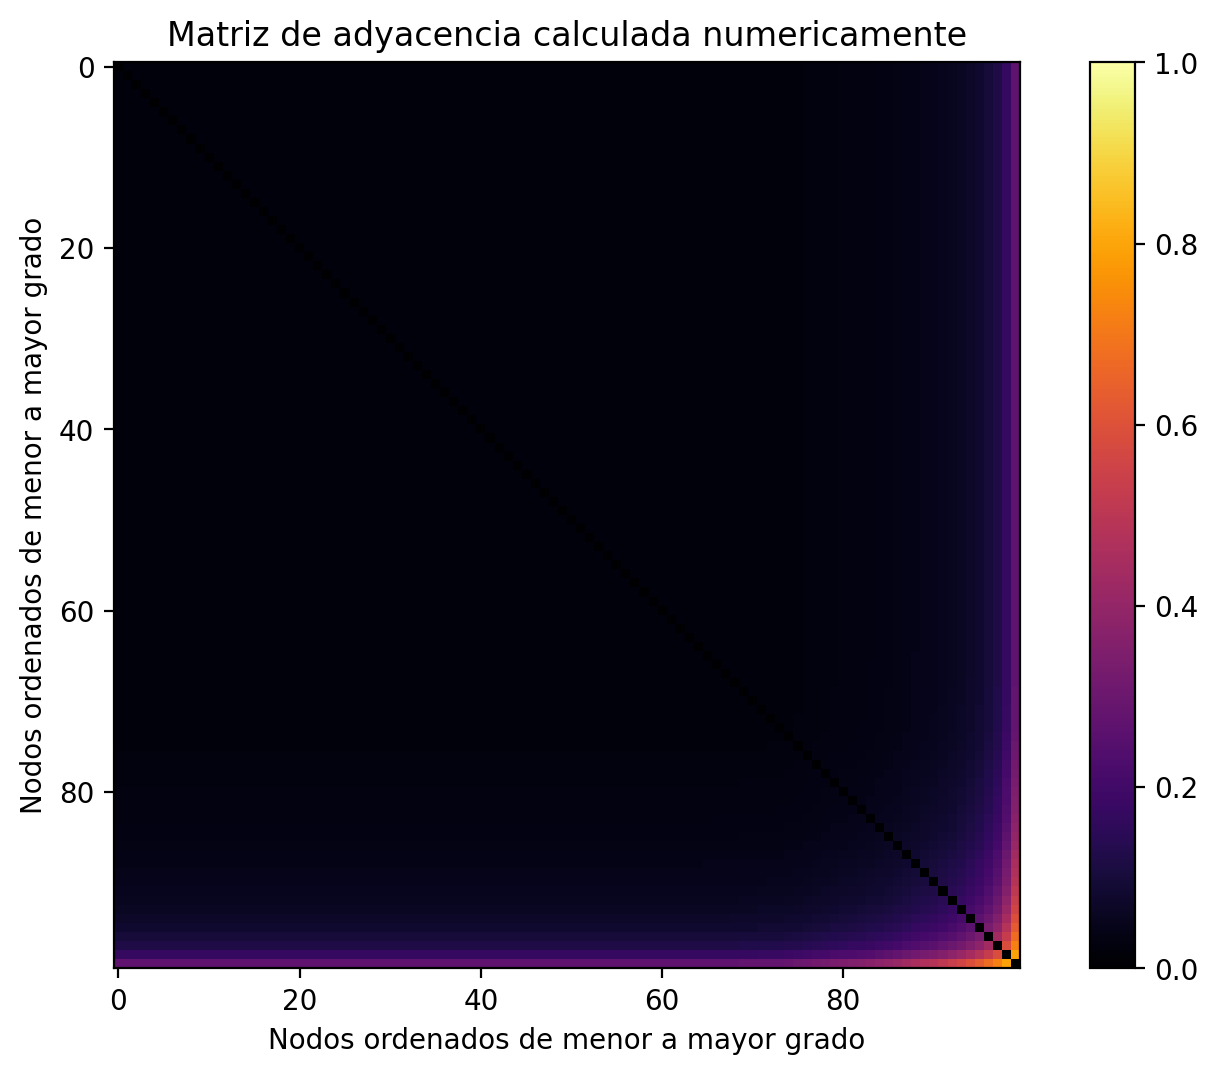

In [ ]:

#tomamos un valor lo suficientemente grande para que la probabilidad acumulada final sea muy proxima a 1
xfin = 30 
num_nodos = 100
num_secuencias = 100
max_grado = num_nodos-1
#creamos el vector de probabilidades acumuladas
P, x = pareto_cumm_probabilities(max_grado,xfin,2.2) 

#Creamos la secuencia de grado promedio 
Sec_prom = Deg_Sec_Prom(100,num_nodos,P,3) 

#creamos los multiplicadores de Lagrange
multipliers = multp_lagrange_canonico(Sec_prom)

#creamos la matriz de adyacencia
adjacencia_numerica = canonical_matrix(multipliers)

#ploteamos y guardamos
fig = plt.figure(figsize=(9,6),dpi = 200)
plt.imshow(adjacencia_numerica,cmap = "inferno",vmin=0,vmax= 1)
plt.title("Matriz de adyacencia calculada numericamente")
plt.xlabel("Nodos ordenados de menor a mayor grado")
plt.ylabel("Nodos ordenados de menor a mayor grado")
plt.colorbar()
plt.savefig("adj_numerica_canonico.jpg", bbox_inches='tight', dpi=300)
plt.show()